<a href="https://colab.research.google.com/github/s83512266/Tibame_AI_111-2_group2_project/blob/main/Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt # seaborn
from PIL import Image

import os # file path
from glob import glob # search files
from tqdm.auto import tqdm # progress bar

import tensorflow as tf
from tensorflow.keras import layers, models, utils

from sklearn.model_selection import train_test_split

# **Read one image**

In [2]:
IMG_SIZE = 256 # 256 128 64

all_class = ['Monstera_Deliciosa', 'Others']
class_map = {cls: i for i, cls in enumerate(all_class)} 
#  'Monstera_Deliciosa':0, 'Others':1
class_map

{'Monstera_Deliciosa': 0, 'Others': 1}

In [3]:
MD_path = glob("/content/drive/MyDrive/圖片/(a.b) 正常龜背芋/train/*.jpg")
Others_path = glob("/content/drive/MyDrive/圖片/(i)非龜背芋種/train/*.jpg")

img_paths = MD_path +  Others_path

# number of images
len(img_paths)

1137

/content/drive/MyDrive/圖片/(i)非龜背芋種/train/62.jpg
(1280, 960, 3)


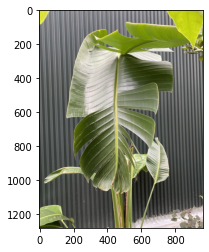

In [30]:
# show image
path = img_paths[700]
img = cv2.imread(path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
print(path)
print(img.shape)
plt.imshow(img)
plt.show()

((3000, 3000, 3), (256, 256, 3))

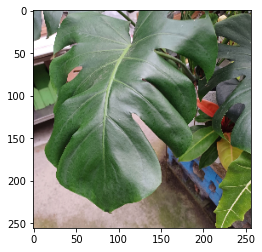

In [5]:
# Resize  img
img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
plt.imshow(img_resized)
img.shape, img_resized.shape

In [6]:
# Extract img class
# os.sep: /
print(path)
cls = path.split(os.sep)[-3]
print(cls)

/content/drive/MyDrive/圖片/(a.b) 正常龜背芋/train/1.jpg
(a.b) 正常龜背芋


In [7]:
# Get file class index for train

# for Monstera_Deliciosa class
if cls == '(a.b) 正常龜背芋':
    cls_idx = class_map["Monstera_Deliciosa"]
    print(cls_idx)
# for sick class
# elif cls == '(b)新葉':
#     cls_idx = class_map["new_leaf"]
#     print(cls_idx)
# for others class
else:
    cls_idx = class_map["Others"]
    print(cls_idx)

0


# **Read all image**

In [8]:
def read_data(paths):
    data_count = len(paths)
    x = np.zeros((data_count, IMG_SIZE, IMG_SIZE, 3)) # model input
    y = np.zeros((data_count, )) # answer

    for i, path in enumerate(tqdm(paths)):
        # read image
        img = cv2.imread(path) # (H, W, 3)
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) # resize
        # Normalization
        img = img / 255. # 0~255 -> 0~1

        # read class index
        cls = path.split(os.sep)[-3]
        
        # for Monstera_Deliciosa class
        if cls == '(a.b) 正常龜背芋':
            cls_idx = class_map["Monstera_Deliciosa"]
        # for new_leaf class
        # elif cls == '(b)新葉':
        #     cls_idx = class_map["new_leaf"]
        # for others class
        else:
            cls_idx = class_map["Others"]
        
        x[i] = img
        y[i] = cls_idx
    return x, y


In [9]:
x, y = read_data(img_paths)

  0%|          | 0/1137 [00:00<?, ?it/s]

In [10]:
x.shape, y.shape

((1137, 256, 256, 3), (1137,))

In [11]:
from sklearn.model_selection import train_test_split
# split train and test dataset
# 90%x, 10%x, 90%y, 10%y
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((1023, 256, 256, 3), (114, 256, 256, 3), (1023,), (114,))

In [12]:
# label count
print(all_class)
# train
unique_classes, counts = np.unique(y_train, return_counts=True)
print(unique_classes, counts)

# test
unique_classes, counts = np.unique(y_test, return_counts=True)
print(unique_classes, counts)

['Monstera_Deliciosa', 'Others']
[0. 1.] [578 445]
[0. 1.] [61 53]


In [13]:
# one-hot encoding
y_train = utils.to_categorical(y_train, num_classes=len(class_map))
y_test = utils.to_categorical(y_test, num_classes=len(class_map))

In [14]:
y_train.shape, y_test.shape

((1023, 2), (114, 2))

# **Build model**

In [15]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False, 
                          weights='imagenet',
                          input_shape=(IMG_SIZE, IMG_SIZE, 3))

x = layers.GlobalAveragePooling2D()(base_model.output) 
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(2, activation='softmax')(x)

# Freeze layers
for l in base_model.layers:
    l.trainable = False

model = models.Model(base_model.input, x)

16705208/16705208 [==============================] - 1s 0us/step


In [16]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 256, 256, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 256, 256, 3)  0           ['normalization[0][0]']      

In [23]:
# y_train是one-hot encoding，不能使用SparseCategoricalCrossentropy()
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [24]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
callbacks = [
    ModelCheckpoint("/content/drive/MyDrive/transfer_best.h5", save_best_only=True),
    # subclassed models不能使用ModelCheckpoint存模型
    EarlyStopping(patience=10, restore_best_weights=True),
    ReduceLROnPlateau(patience=3, factor=0.3)
    # 當模型連續訓練n次沒有更好，就進行一次學習率衰降。
]

In [25]:
logs = model.fit(x_train, y_train,
          batch_size=4,
          epochs=100,
          validation_split=0.1,
          callbacks=callbacks
    )

Epoch 1/100
230/230 [==============================] - 14s 39ms/step - loss: 0.6859 - accuracy: 0.5620 - val_loss: 0.6782 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 2/100
230/230 [==============================] - 4s 17ms/step - loss: 0.6863 - accuracy: 0.5620 - val_loss: 0.6787 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 3/100
230/230 [==============================] - 4s 17ms/step - loss: 0.6857 - accuracy: 0.5620 - val_loss: 0.6783 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 4/100
230/230 [==============================] - 4s 17ms/step - loss: 0.6856 - accuracy: 0.5620 - val_loss: 0.6785 - val_accuracy: 0.5922 - lr: 0.0010
Epoch 5/100
230/230 [==============================] - 4s 17ms/step - loss: 0.6855 - accuracy: 0.5620 - val_loss: 0.6784 - val_accuracy: 0.5922 - lr: 3.0000e-04
Epoch 6/100
230/230 [==============================] - 4s 17ms/step - loss: 0.6855 - accuracy: 0.5620 - val_loss: 0.6783 - val_accuracy: 0.5922 - lr: 3.0000e-04
Epoch 7/100
230/230 [============================

# **Training log**

In [20]:
history = logs.history
min_loss_epoch = np.argmin(history['val_loss'])
print('min_loss_epoch: ', min_loss_epoch+1)
print('val loss ', history['val_loss'][min_loss_epoch])
print('val acc', history['val_accuracy'][min_loss_epoch])

min_loss_epoch:  12
val loss  0.6778218746185303
val acc 0.5922330021858215


Text(0.5, 1.0, 'accuracy')

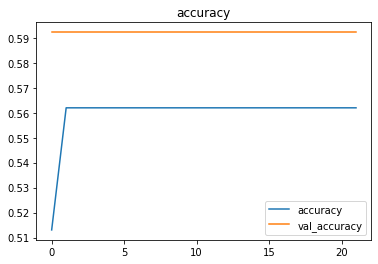

In [21]:
plt.plot(history['accuracy'])
plt.plot(history['val_accuracy'])
plt.legend(['accuracy', 'val_accuracy'])
plt.title('accuracy')

Text(0.5, 1.0, 'loss')

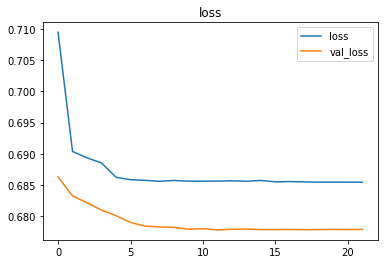

In [22]:
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.title('loss')

# **Evaluate**

In [26]:
model.evaluate(x_test, y_test)

4/4 [==============================] - 1s 217ms/step - loss: 0.6919 - accuracy: 0.5351


[0.6919317841529846, 0.5350877046585083]

In [27]:
from sklearn.metrics import classification_report, confusion_matrix

y_true = np.argmax(y_test, axis=-1) # [0, 1, 2, ...]

prediction = model.predict(x_test)
y_pred = np.argmax(prediction, axis=-1) # [0, 1, 2, ...]

print(y_true.shape, y_pred.shape)

4/4 [==============================] - 2s 89ms/step
(114,) (114,)


In [28]:
# classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.54      1.00      0.70        61
           1       0.00      0.00      0.00        53

    accuracy                           0.54       114
   macro avg       0.27      0.50      0.35       114
weighted avg       0.29      0.54      0.37       114



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [29]:
import pandas as pd
# Confusion matrix:
#   row: Ground truth
#   column: predict
mat = confusion_matrix(y_true, y_pred)
pd.DataFrame(mat,
      columns=["{}(predict)".format(all_class[i]) for i in range(2)],
      index=["{}(true)".format(all_class[i]) for i in range(2)])

,Monstera_Deliciosa(predict),Others(predict)
Monstera_Deliciosa(true),61,0
Others(true),53,0


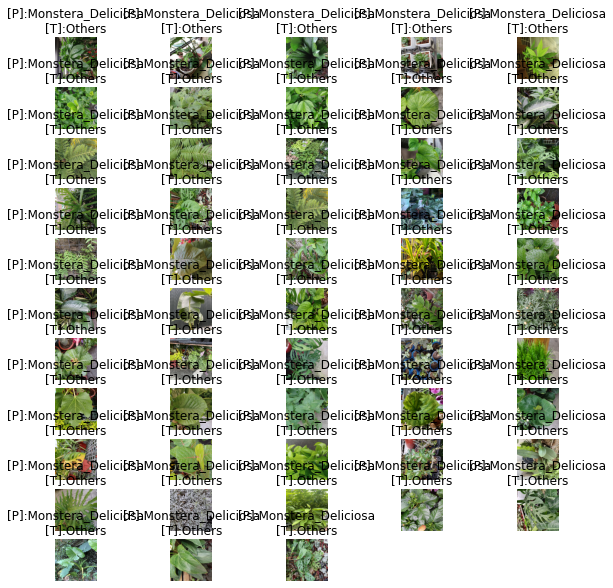

In [31]:
plt.figure(figsize=(10, 10))

idx = np.nonzero(y_pred != y_true)[0]

false_pre = y_pred[idx]
false_true = y_true[idx]
false_img = x_test[idx]

width = 5
height = len(idx) // width + 1

for i in range(len(idx)):
    plt.subplot(height, width, i+1)
    title = "[P]:{}\n[T]:{}".format(all_class[false_pre[i]], all_class[false_true[i]])
    plt.title(title)
    plt.axis("off")
    for j in range(len(false_img)):
        false_img[j]
    plt.imshow(false_img[i][:, :, ::-1])

# **Save model**

In [ ]:
# 1. save whole model and weights
# model.save('/content/drive/MyDrive/my_model.h5')
# 2. save and load weights only
# model.save_weights('/content/drive/MyDrive/CLF_model_weights.h5')

# **Load model**

In [ ]:
# 1. load whole model and weights
# model2 = models.load_model('my_model.h5')
# 2. Rebuild model before load weights !
# model2 = MyModel()
# model2.load_weights('CLF_model_weights.h5')

# **Predict image**

In [ ]:
import requests

url = input("輸入一個網址")
h = {
    "user-agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/105.0.0.0 Safari/537.36"
}

response = requests.get(url, stream=True, verify=False, headers=h)
img = Image.open(response.raw)
img_r = img.convert("RGB").resize((256, 256))
img_r = np.array(img_r).reshape(1, 256, 256, 3) / 255.0
proba = model.predict(img_r)[0]
for t, p in zip(all_class, proba):
    print(t, "的機率:", p)
ans = all_class[proba.argmax(axis=-1)]
print("答案是:", ans)
plt.imshow(img)